# 1. Import and clean data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed, save, load
import warnings
warnings.filterwarnings("ignore")
set_random_seed(99)

C:\Users\namtrantuan\AppData\Roaming\Python\Python39\site-packages\plotly_resampler\aggregation\aggregators.py:25: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


In [2]:
pd.options.display.float_format = '{:20,.0f}'.format

In [3]:
dom = pd.read_excel('TTT.xlsx')

In [4]:
dom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134316 entries, 0 to 134315
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   YEAR       134316 non-null  int64         
 1   FLT_MONTH  134316 non-null  int64         
 2   FLT_DATE   134316 non-null  datetime64[ns]
 3   week       134316 non-null  int64         
 4   SECTOR_2W  134316 non-null  object        
 5   Pax        134316 non-null  float64       
 6   seat       134316 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 7.2+ MB


In [5]:
dom

,YEAR,FLT_MONTH,FLT_DATE,week,SECTOR_2W,Pax,seat
0,2015,1,2015-01-01,1,DADBMV,134,136
1,2015,1,2015-01-01,1,DADHPH,203,272
2,2015,1,2015-01-01,1,DADPXU,123,136
3,2015,1,2015-01-01,1,DADVCA,334,360
4,2015,1,2015-01-01,1,DADVII,118,136
...,...,...,...,...,...,...,...
134311,2023,3,2023-03-27,13,SGNVDH,251,368
134312,2023,3,2023-03-27,13,SGNVII,753,1180
134313,2023,3,2023-03-27,13,SGNHPH,"1,018",1326
134314,2023,3,2023-03-27,13,SGNHUI,"1,183",1586


In [6]:
# df for model building:
df = dom[['FLT_DATE','SECTOR_2W','Pax','seat']]

In [7]:
df.rename(columns = {'SECTOR_2W':'ID','FLT_DATE':'ds','Pax':'y'}, inplace = True)

In [8]:
# changepoints là những mốc bắt đầu và kết thúc của các đợt dịch covid hoặc thay đổi về trend:
changepoints = ['2020-03-09',
                '2020-05-31',
                '2020-07-28',
                '2020-09-30']

In [9]:
df

,ds,ID,y,seat
0,2015-01-01,DADBMV,134,136
1,2015-01-01,DADHPH,203,272
2,2015-01-01,DADPXU,123,136
3,2015-01-01,DADVCA,334,360
4,2015-01-01,DADVII,118,136
...,...,...,...,...
134311,2023-03-27,SGNVDH,251,368
134312,2023-03-27,SGNVII,753,1180
134313,2023-03-27,SGNHPH,"1,018",1326
134314,2023-03-27,SGNHUI,"1,183",1586


# 2. Build model

## 2.1. Routes with only route peaks

In [10]:
route = df[df['ID']=='HANSGN'][['ds','y','seat']]

In [11]:
route

,ds,y,seat
30,2015-01-01,"13,405",16414
66,2015-01-02,"12,142",15546
107,2015-01-03,"12,304",15594
144,2015-01-04,"15,869",17611
183,2015-01-05,"14,502",16989
...,...,...,...
134153,2023-03-23,"8,945",10239
134187,2023-03-24,"9,780",11891
134222,2023-03-25,"7,396",9642
134253,2023-03-26,"8,368",10512


In [12]:
train = route[route['ds'] < '2022-07-01'].copy()
val = route[(route['ds'] >= '2022-07-01')&(route['ds'] < '2023-01-01')].copy()
test = route[route['ds'] >= '2023-01-01'].copy()

In [13]:
holidays = pd.read_excel('holidays.xlsx')
holidays = holidays.rename(columns={'holiday': 'event'})
holidays = holidays[holidays['event'].isin(['Lunar','Labor'])]

In [14]:
train_holidays = holidays[holidays['ds'] < '2022-07-01'].copy()
val_holidays = holidays[(holidays['ds'] >= '2022-07-01')&(holidays['ds'] < '2023-01-01')].copy()
test_holidays = holidays[holidays['ds'] >= '2023-01-01'].copy()

In [15]:
def objective(trial):
    set_random_seed(99)
    """Define the objective function"""

    params = {
        'trend_reg': trial.suggest_float('trend_reg',0.001,10),
        'seasonality_reg': trial.suggest_float('seasonality_reg',0.1, 10),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode',['multiplicative', 'additive']),
        'yearly_seasonality':trial.suggest_int('yearly_seasonality',10,40),
        'weekly_seasonality':trial.suggest_int('weekly_seasonality',1,20),
        'n_lags':trial.suggest_int('n_lags',1,365*3),
        'ar_reg':trial.suggest_float('ar_reg',0,10),
        #'newer_samples_weight':trial.suggest_float('newer_samples_weight',0,10),
        'learning_rate':trial.suggest_float('learning_rate',0.001,5),
        'num_hidden_layers':trial.suggest_int('num_hidden_layers',0,3)
    }
    lagged_regressor_params = {'regularization':trial.suggest_float('regularization',0,1)}
    
    # Create the model
    optuna_model = NeuralProphet(**params,
                                 changepoints = changepoints,
                                 daily_seasonality = False,
                                 n_forecasts = 365)
    optuna_model.add_events(events = ['covid_1','covid_2','covid_3','covid_4'], mode='multiplicative')  
    optuna_model.add_events(events = ['Lunar','Labor'], mode='multiplicative')
    optuna_model.add_lagged_regressor('seat', **lagged_regressor_params)
    
    # create the data df with events
    train_df = optuna_model.create_df_with_events(train, train_holidays)
    val_df = optuna_model.create_df_with_events(val, val_holidays)
    
    # Fit the model
    metrics = optuna_model.fit(train_df, freq="D")

    # Make predictions
    future_df = optuna_model.make_future_dataframe(train_df, events_df=holidays)
    optuna_forecast = optuna_model.predict(df=future_df)
    latest = optuna_model.get_latest_forecast(optuna_forecast)

    # Evaluate prediction
    result = val_df.merge(latest,how = 'left', on = 'ds')
    result.set_index('ds', inplace = True)
    rmse = np.sqrt(mean_squared_error(result['y_x'], result['origin-0'])).round(0)
    return rmse

In [16]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=99))

[I 2023-04-13 08:58:13,496] A new study created in memory with name: no-name-edcc4469-6e34-4466-8099-5e1eb915808c


In [17]:
# study.optimize(objective, n_trials=50)

In [18]:
# params =  study.best_trial.params
params = {'trend_reg': 9.914507743186018, 'seasonality_reg': 5.4270390305539, 'seasonality_mode': 'additive', 'yearly_seasonality': 11, 'weekly_seasonality': 8, 'n_lags': 822, 'ar_reg': 5.770896226506226, 'learning_rate': 4.010909518907745, 'num_hidden_layers': 3, 'regularization': 0.12540477902922895}

In [19]:
regularization = params.pop('regularization')

In [20]:
set_random_seed(99)

In [21]:
m = NeuralProphet(**params,
                  changepoints = changepoints,
                  daily_seasonality = False,
                  n_forecasts = 365)
m.add_events(events = ['covid_1','covid_2','covid_3','covid_4'], mode='multiplicative')
m.add_events(events = ['Lunar','Labor'], mode='multiplicative')
m.add_lagged_regressor('seat', regularization = regularization)

# create the data df with events
train_df = m.create_df_with_events(train, train_holidays)
val_df = m.create_df_with_events(val, val_holidays)
train_val_df = pd.concat([train_df,val_df])
test_df = m.create_df_with_events(test, test_holidays)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (822)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.897% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.forecaster.__handle_missing_data) - 2 missing dates added.
WARNING - (NP.forecaster.__handle_missing_data) - 2 missing values in column y were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 2 NaN values in column y were auto-imputed.
WARNING - (NP.forecaster.__handle_missing_data) - 2 missing values in column seat were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 2 NaN values in column seat were auto-imputed.
WARNING - (NP.forecaster.__handle_missing_data) - 2 missing values in column covid_1 were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 2 NaN values in column covid_1 were auto-imputed.
WARNING - (NP.forecas

Training: 0it [00:00, ?it/s]

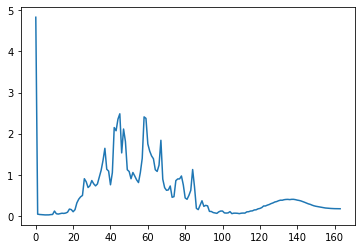

In [22]:
metrics = m.fit(train_val_df,
                freq="D",
                progress="plot")

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


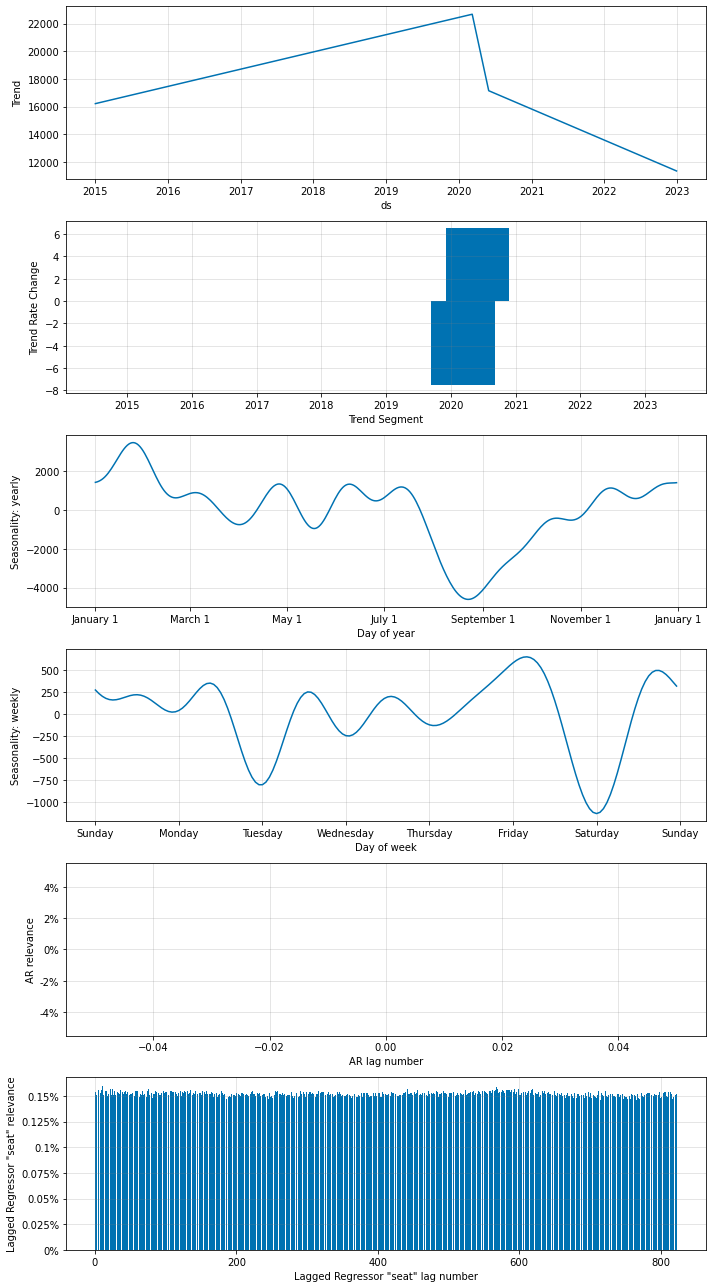

In [23]:
fig_param = m.plot_parameters()

In [24]:
future = m.make_future_dataframe(train_val_df, n_historic_predictions=True, events_df=holidays)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.897% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [25]:
future[(future['ds']>='2023-01-01')&(future['ds']<'2023-03-01')]

,ds,y,seat,covid_1,covid_2,covid_3,covid_4,Lunar,Labor
2920,2023-01-01,NaN,None,0,0,0,0,0,0
2921,2023-01-02,NaN,None,0,0,0,0,0,0
2922,2023-01-03,NaN,None,0,0,0,0,0,0
2923,2023-01-04,NaN,None,0,0,0,0,0,0
2924,2023-01-05,NaN,None,0,0,0,0,0,0
2925,2023-01-06,NaN,None,0,0,0,0,0,0
2926,2023-01-07,NaN,None,0,0,0,0,0,0
2927,2023-01-08,NaN,None,0,0,0,0,0,0
2928,2023-01-09,NaN,None,0,0,0,0,0,0
2929,2023-01-10,NaN,None,0,0,0,0,0,0


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.forecaster.__handle_missing_data) - 2 missing dates added.
WARNING - (NP.forecaster.__handle_missing_data) - 2 missing values in column y were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 2 NaN values in column y were auto-imputed.
WARNING - (NP.forecaster.__handle_missing_data) - 2 missing values in column seat were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 2 NaN values in column seat were auto-imputed.
WARNING - (NP.forecaster.__handle_missing_data) - 2 missing values in column covid_1 were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 2 NaN val

Predicting: 55it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.plot) - Legend is available only for the ten first handles


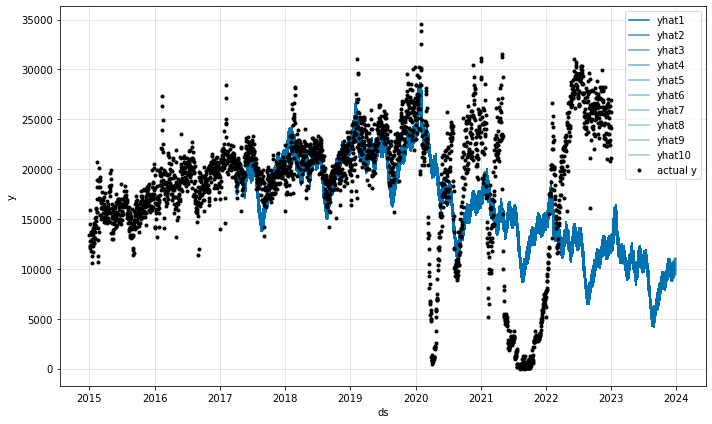

In [26]:
forecast = m.predict(future, decompose = False)
fig = m.plot(forecast)

In [27]:
latest = m.get_latest_forecast(forecast,include_history_data=True)

In [28]:
result = test_df.merge(latest,how = 'left', on = ['ds'])

In [29]:
result.to_excel('forecast.xlsx')

In [30]:
save(m,'HANSGN_daily.np')